# Prediction for a GP using the Poisson Likelihood?

Alan wrote a tutorial about how to handle count data in GPy <a href="https://notebook.community/SheffieldML/notebook/GPy/Poisson%20regression%20tutorial">here</a>. In a figure in the notebook he plots the predicted number of counts, with uncertainty:

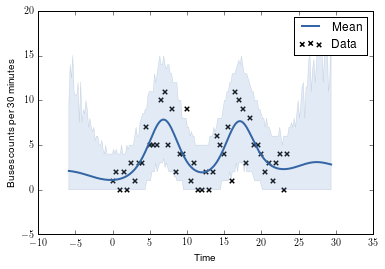

I've not looked into how this is computed.

This is my initial thoughts...

In Chapter 3 of Rasmussen and Williams the look at using various approximations to allow non-Gaussian likelihoods. In particular they look at classification. For this they have a sigmoid squashing function (to get the value to lie between 0 and 1). In our case we use an exponential squashing function (to make the value positive, and also reflect maybe the logrithmic pattern in the data?).

Once you have a prediction of the latent posterior at a test point, we want to then estimate an actual prediction.

Let us consider, for simplicity, that our prediction of the latent function is:

$$q(f_* | X, y, x_*) \sim N(1.5,0.5)$$

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats, special

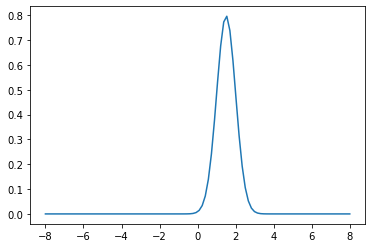

In [31]:
a = np.linspace(-8,8,100)
plt.plot(a,stats.norm.pdf(a,1.5,0.5))

So what is the prediction? Let's first consider the example from the textbook where it is squashed with a sigmoid, let's use the logistic, and we'll consider 4 different latent posteriors, to illustrate:

$$q(f_* | X, y, x_*) \sim N(1.5,0.5)$$

$$q(f_* | X, y, x_*) \sim N(1.5,2.0)$$

$$q(f_* | X, y, x_*) \sim N(0,3)$$

$$q(f_* | X, y, x_*) \sim N(2.5,0.5)$$

We want to find $p(y=1)$, which we can do by integrating out the latent function values, $f_*$, i.e.: $$p(y=1) = \int p(y=1,f_*) \; df_* = \int p(y=1|f_*) p(f_*) \; df_*$$

Which in our case is:

$$\bar{\pi}_* = \int Bernoulli(y=1|\sigma(f_*)) q(f_* | X, y, x_*) df_*$$

which for the special case of classification, $Bernoulli(y=1|p) = p$, so:

$$\bar{\pi}_* = \int \sigma(f_*) q(f_* | X, y, x_*) df_*$$

This gives, for test point $x_*$ the probability of $y=1$.

In the plots below, I've put the integral's total in the title.

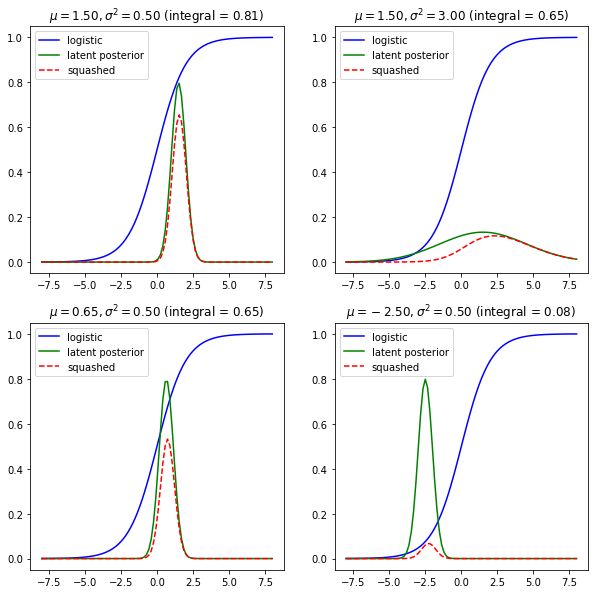

In [35]:
plt.figure(figsize=[10,10])
for i,(mean,var) in enumerate([(1.5,0.5),(1.5,3),(0.65,0.5),(-2.5,0.5)]):
    plt.subplot(2,2,i+1)
    
    plt.plot(a,special.expit(a),'b',label='logistic')
    plt.plot(a,stats.norm.pdf(a,mean,var),'g',label='latent posterior')
    plt.plot(a,stats.norm.pdf(a,mean,var)*special.expit(a),'--r',label='squashed')
    plt.legend()
    tot = np.sum(stats.norm.pdf(a,mean,var)*special.expit(a))*(a[1]-a[0])
    plt.title('$\mu=%0.2f, \sigma^2=%0.2f$ (integral = %0.2f)' % (mean,var,tot))

It is interesting to note there's two sources of uncertainty in $\bar{\pi}_*$. One could either have a lataent posterior mean near zero (as in the lower-left plot) or the variance could be large (as in the upper-right plot).

So does this apply to our exponentiated squashing function? Let's see... Not exactly. We can only do the above because the probability of $y=1$ is **equal to the value of our squashed function**: $\sigma(f_*)$, thanks to the simple Bernoulli distribution. In our case, the probability of, say, $y=2$ is computed from the Poisson distribution, with rate, $\lambda = \sigma(f_*)$. So we need:

$$\bar{\pi}_*(y=2) = \int Poisson(y=2|\lambda=\sigma(f_*)) q(f_* | X, y, x_*) df_*$$

where $\sigma(\cdot)$ is, say, the exponential function.

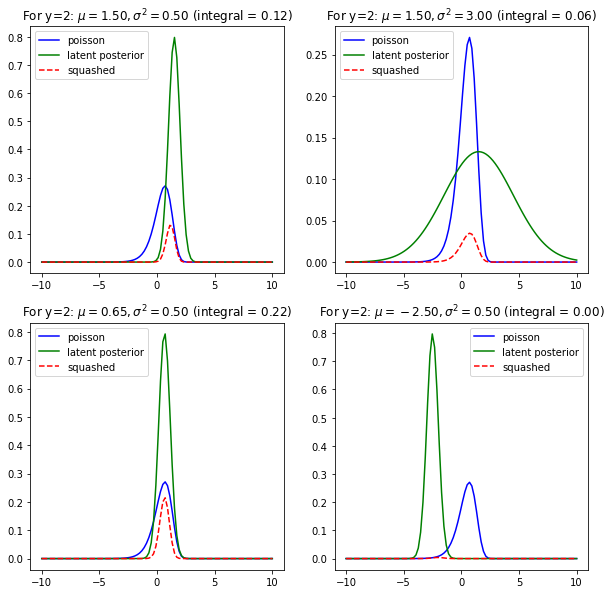

In [57]:
plt.figure(figsize=[10,10])
a = np.linspace(-10,10,100)
for i,(mean,var) in enumerate([(1.5,0.5),(1.5,3),(0.65,0.5),(-2.5,0.5)]):
    plt.subplot(2,2,i+1)
    plt.plot(a,stats.poisson(np.exp(a)).pmf(2),'b',label='poisson')
    plt.plot(a,stats.norm.pdf(a,mean,var),'g',label='latent posterior')
    plt.plot(a,stats.norm.pdf(a,mean,var)*stats.poisson(np.exp(a)).pmf(2),'--r',label='squashed')
    tot = np.sum(stats.norm.pdf(a,mean,var)*stats.poisson(np.exp(a)).pmf(2))*(a[1]-a[0])
    plt.title('For y=2: $\mu=%0.2f, \sigma^2=%0.2f$ (integral = %0.2f)' % (mean,var,tot))
    plt.legend()
    #plt.ylim([0,1])

You're interested in computing the NLPD, so the above is all you need: You can just use whatever the value of the $\bar{\pi}_*$ is, in your computation of the NLPD.

But, just for completeness, we can look at different values of $y$. Also this reassures us that p(y) computed above is a probability distribution (sums to 1).


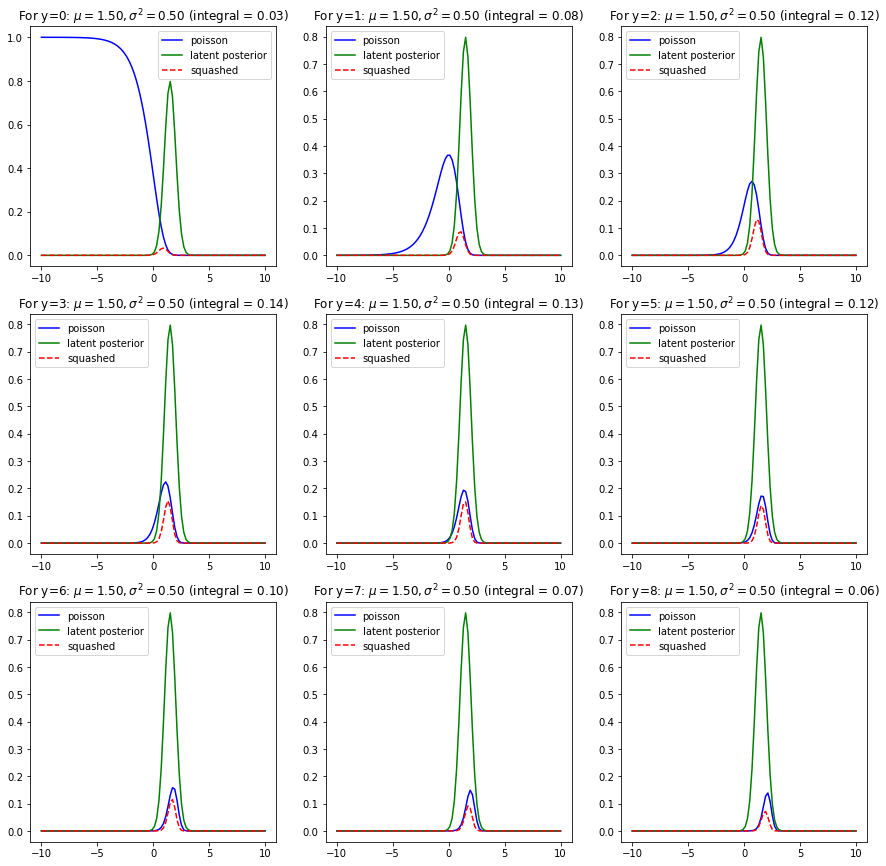

In [58]:
plt.figure(figsize=[15,15])
a = np.linspace(-10,10,100)
res = []
ys = np.arange(20)
for i,y in enumerate(ys):
    mean,var = 1.5,0.5
    tot = np.sum(stats.norm.pdf(a,mean,var)*stats.poisson(np.exp(a)).pmf(y))*(a[1]-a[0])
    res.append(tot)
    if i>8: continue
    plt.subplot(3,3,i+1)
    plt.plot(a,stats.poisson(np.exp(a)).pmf(y),'b',label='poisson')
    plt.plot(a,stats.norm.pdf(a,mean,var),'g',label='latent posterior')
    plt.plot(a,stats.norm.pdf(a,mean,var)*stats.poisson(np.exp(a)).pmf(y),'--r',label='squashed')
    
    plt.title('For y=%d: $\mu=%0.2f, \sigma^2=%0.2f$ (integral = %0.2f)' % (y,mean,var,tot))
    plt.legend()
    
    
    #plt.ylim([0,1])

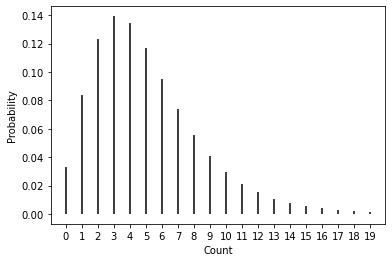

In [71]:
plt.vlines(ys,np.zeros(20),res)
plt.xticks(np.arange(0,20),np.arange(0,20))
plt.xlabel('Count')
plt.ylabel('Probability');

In [67]:
print("The sum of p(y) is %0.3f, which is roughly 1." % np.sum(res))

The sum of p(y) is 0.996, which is roughly 1.
